# Clickbait Image Classifier Pipeline

This notebook demonstrates the end-to-end process for building, evaluating, and interpreting an image-based clickbait classifier.

## Table of Contents
1. [Introduction](#introduction)
2. [Data Loading & Exploration](#data-loading)
3. [Preprocessing](#preprocessing)
4. [Model Building](#model-building)
5. [Training](#training)
6. [Evaluation](#evaluation)
7. [Feature Visualization](#feature-visualization)
8. [Prediction Demo](#prediction-demo)
9. [Retraining Trigger](#retraining-trigger)

---

## 1. Introduction <a id='introduction'></a>

This notebook walks through the process of building a convolutional neural network (CNN) to classify images as clickbait or not. The pipeline includes data loading, preprocessing, model training, evaluation, and visualization of results.

In [45]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import random

# Set paths
DATA_DIR = '../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
MODEL_PATH = '../models/clickbait_cnn.h5'
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

## 2. Data Loading & Exploration <a id='data-loading'></a>

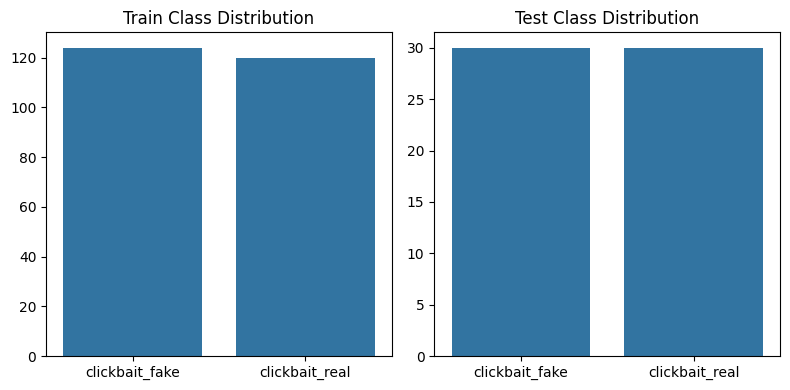

Train: {'clickbait_fake': 124, 'clickbait_real': 120}
Test: {'clickbait_fake': 30, 'clickbait_real': 30}


In [46]:
# Visualize class distribution
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title('Train Class Distribution')
plt.subplot(1,2,2)
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()))
plt.title('Test Class Distribution')
plt.tight_layout()
plt.show()

print('Train:', train_counts)
print('Test:', test_counts)

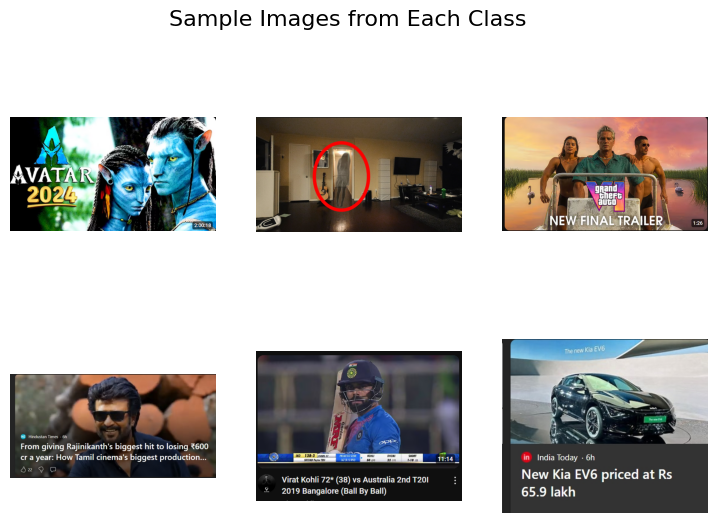

In [47]:
# Show random sample images from each class
def show_samples(directory, n=3):
    plt.figure(figsize=(n*3, 6))
    class_names = os.listdir(directory)
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        images = os.listdir(class_path)
        samples = random.sample(images, min(n, len(images)))
        for j, img_name in enumerate(samples):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            plt.subplot(len(class_names), n, idx*n + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.ylabel(class_name, fontsize=14)
    plt.suptitle('Sample Images from Each Class', fontsize=16)
    plt.show()

show_samples(TRAIN_DIR, n=3)

## 3. Preprocessing <a id='preprocessing'></a>

In [48]:
# Data generators with augmentation for training, only rescaling for test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=SEED
)

print('Class indices:', train_gen.class_indices)

Found 244 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Class indices: {'clickbait_fake': 0, 'clickbait_real': 1}


## 4. Model Building <a id='model-building'></a>

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False  # Freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Call the model once with dummy data to build it
dummy_input = np.zeros((1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=np.float32)
_ = model.predict(dummy_input)
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 5. Training <a id='training'></a>

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8232 - loss: 0.3956
Epoch 1: val_accuracy improved from -inf to 0.71667, saving model to ../models/clickbait_cnn.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.8242 - loss: 0.3934 - val_accuracy: 0.7167 - val_loss: 0.5629
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8872 - loss: 0.3142
Epoch 2: val_accuracy did not improve from 0.71667
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.8847 - loss: 0.3181 - val_accuracy: 0.7000 - val_loss: 0.6916
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8853 - loss: 0.2955
Epoch 3: val_accuracy improved from 0.71667 to 0.75000, saving model to ../models/clickbait_cnn.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.8858 - loss: 0.2974 - val_accuracy: 0.7500 - val_loss: 0.5511
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8735 - loss: 0.2996
Epoch 4: val_accuracy did not improve from 0.75000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.8717 - loss: 0.3013 - val_accuracy: 0.6833 - val_loss: 0.7370
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8975 - loss: 0.3261
Epoch 5: val_accuracy did not improve from 0.75000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.8994 - loss: 0.3202 - val_accuracy: 0.7333 - val_loss: 0.5771
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9283 - loss: 0.2290
Epoch 6: val_accuracy did not improve from 0.75000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.9272 - loss: 0.2298 - val_accuracy: 0.7333 - val_loss: 0.6135
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8796 - loss: 0.2618
Epoch 7: val_accuracy did not improve from 0.75000


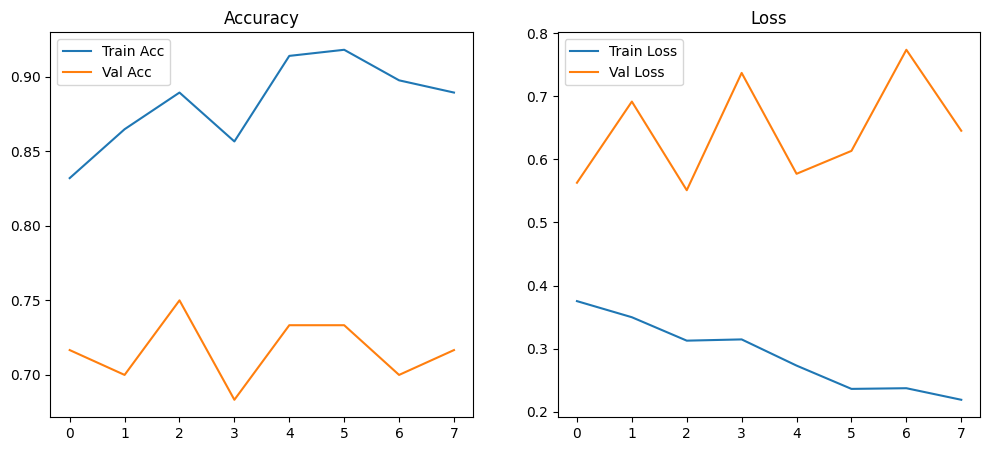

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

EPOCHS = 20

checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=test_gen,
    callbacks=[checkpoint, early_stop],
    class_weight=dict(enumerate(class_weights))
)

# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

## 6. Evaluation <a id='evaluation'></a>

In [ ]:
# Load best model
best_model = load_model(MODEL_PATH)

# Predict on test set
test_gen.reset()
preds = best_model.predict(test_gen, verbose=1)
y_pred = (preds > 0.5).astype(int).flatten()
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 7. Feature Visualization <a id='feature-visualization'></a>

Let's interpret what the model is learning using Grad-CAM for a few test images.

In [ ]:
# # Grad-CAM visualization for a test image
# import tensorflow as tf
# from tensorflow.keras.preprocessing import image

# def get_img_array(img_path, size):
#     img = image.load_img(img_path, target_size=size)
#     array = image.img_to_array(img)
#     array = np.expand_dims(array, axis=0)
#     array = array / 255.0
#     return array

# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     grad_model = tf.keras.models.Model(
#         [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
#     )
#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(predictions[0])
#         class_channel = predictions[:, pred_index]
#     grads = tape.gradient(class_channel, conv_outputs)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     conv_outputs = conv_outputs[0]
#     heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()

# # Pick a random test image
# test_class = random.choice(os.listdir(TEST_DIR))
# test_img_name = random.choice(os.listdir(os.path.join(TEST_DIR, test_class)))
# test_img_path = os.path.join(TEST_DIR, test_class, test_img_name)

# img_array = get_img_array(test_img_path, IMAGE_SIZE)
# conv_layers = [layer.name for layer in best_model.layers if 'conv2d' in layer.name]
# last_conv_layer_name = conv_layers[-1]
# print("Using last Conv2D layer:", last_conv_layer_name)

# heatmap = make_gradcam_heatmap(img_array, best_model, last_conv_layer_name=last_conv_layer_name)
# # Display heatmap
# import cv2
# img = cv2.imread(test_img_path)
# img = cv2.resize(img, IMAGE_SIZE)
# heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# heatmap = np.uint8(255 * heatmap)
# heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.title('Original Image')
# plt.axis('off')
# plt.subplot(1,2,2)
# plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
# plt.title('Grad-CAM Heatmap')
# plt.axis('off')
# plt.suptitle(f'Grad-CAM for {test_class}', fontsize=16)
# plt.show()

## 8. Prediction Demo <a id='prediction-demo'></a>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


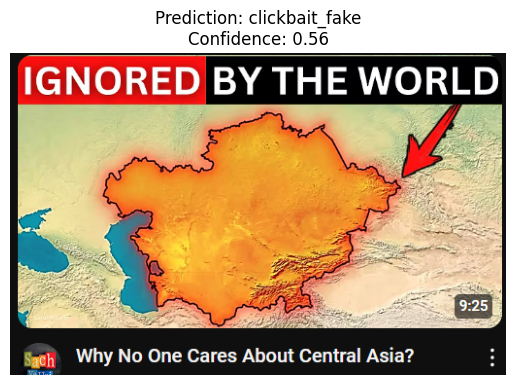

Prediction: clickbait_fake (confidence: 0.56)


In [56]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def predict_image(img_path, model, image_size=(128, 128)):
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0][0]
    label = 'clickbait_real' if pred > 0.5 else 'clickbait_fake'
    confidence = float(pred) if label == 'clickbait_real' else 1 - float(pred)
    return label, confidence

# Example usage
test_img_path = "../data/test/clickbait_real/brave_screenshot_www.youtube.com (100).png"
label, confidence = predict_image(test_img_path, best_model)

img = image.load_img(test_img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Prediction: {label}\nConfidence: {confidence:.2f}')
plt.show()

print(f'Prediction: {label} (confidence: {confidence:.2f})')


## 9. Retraining Trigger <a id='retraining-trigger'></a>

You can retrain the model by running the training cells again or by calling the retraining endpoint in the API.

In [57]:
# Save the trained model to the models directory with a new name
model.save("../models/clickbait_cnn.h5")